# NOTICE

The predict value is not accurate unless the confirm/deaths/recorverd has a huge increasement duration > 2-3 weeks, so please not be scared and keep patient. Figures are for reference only.

**NOTE:**
* The model inherited from this notebook : https://www.kaggle.com/alixmartin/covid-19-predictions
* Use the Github data to predict newest cases https://github.com/CSSEGISandData/COVID-19
* Can prediction Confirmed / Deaths / Recovered / Active cases
* Can prediction by specify Province and Country 
* World prediction (With China Data / Without China Data)
* I will update the prediction every day (Last Update 2020/03/31 1:30 UCT)

**Please vote if you like!**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [2]:
#check the old format
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0
...,...,...,...,...,...,...
16486,Anguilla,United Kingdom,2020-03-30,2,0,0
16487,British Virgin Islands,United Kingdom,2020-03-30,2,0,0
16488,Turks and Caicos Islands,United Kingdom,2020-03-30,5,0,0
16489,,MS Zaandam,2020-03-30,2,0,0


### Cleaning Data

In [3]:
# cases 
#cases = ['Confirmed', 'Deaths', 'Recovered', 'Active']

# Active Case = confirmed - deaths - recovered
full_table['Active'] = full_table['Confirmed'] - full_table['Deaths'] - full_table['Recovered']

# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values 
full_table[['Province/State']] = full_table[['Province/State']].fillna('')
# full_table[cases] = full_table[cases].fillna(0)
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,,Afghanistan,2020-01-22,0,0,0,0
1,,Albania,2020-01-22,0,0,0,0
2,,Algeria,2020-01-22,0,0,0,0
3,,Andorra,2020-01-22,0,0,0,0
4,,Angola,2020-01-22,0,0,0,0
...,...,...,...,...,...,...,...
16486,Anguilla,United Kingdom,2020-03-30,2,0,0,2
16487,British Virgin Islands,United Kingdom,2020-03-30,2,0,0,2
16488,Turks and Caicos Islands,United Kingdom,2020-03-30,5,0,0,5
16489,,MS Zaandam,2020-03-30,2,0,0,2


In [4]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered', 'Active'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered', 'Active']]

data looks a bit dirty, we might get an overly optimistic prediction because the last number is not the final one for instance.

The model is quite sensitive to this as it has only a handful of points to infer the dynamics from.


In [5]:
country = 'China'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-03-21,81305,3259,71857,6189
2020-03-22,81435,3274,72362,5799
2020-03-23,81498,3274,72814,5410
2020-03-24,81591,3281,73280,5030
2020-03-25,81661,3285,73773,4603
2020-03-26,81782,3291,74181,4310
2020-03-27,81897,3296,74720,3881
2020-03-28,81999,3299,75100,3600
2020-03-29,82122,3304,75582,3236


We use china data to build model.

# Model

I will use a model from a marketing paper by Emmanuelle Le Nagard and Alexandre Steyer, that attempts to reflect the social structure of a diffusion process. Their application was the diffusion of innovations, not epidemics. However, there are commonalities in both domains, as the number of contacts each infected person / innovation adopter has seems relevant. It also has the added benefit to allow fitting parameters to the beginning of a time series.

paper is available (in French) [here](https://www.jstor.org/stable/40588987)

The model is also sensitive to when we define the origin of time for the epidemic process. Here, I just took the first point of the time series available, but adding a lag parameter could be attempted.

In [6]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

In [7]:
model_index = 0

def model_loss(params):
#     N, a, alpha, lag = params
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
#         r += (math.log(1 + model(N, a, alpha, t)) - math.log(1 + df.iloc[t, 0])) ** 2 
#         r += (model_with_lag(N, a, alpha, lag, t) - df.iloc[t, 0]) ** 2
#         print(model(N, a, alpha, t), df.iloc[t, 0])
    return math.sqrt(r) 

we need to explore the 3d parameter space to find a minimum, using gradient descent. There are a number of algorithms to do that in scipy.optimize, I stopped at the first one that seemed to work. Generalized Reduced Gradient as in Excel solver also works.

In [8]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x

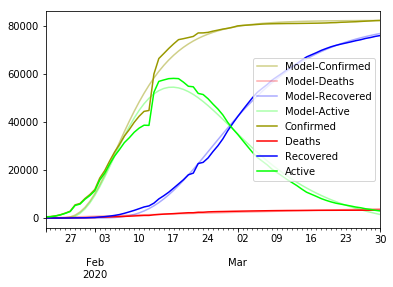

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()

Curve look perfect, let's extend the prediction curve

China COVID-19 Prediction


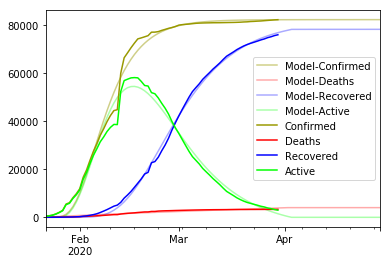

In [10]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0

plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('China COVID-19 Prediction')
plt.show()

let's display predictions for future weeks

In [11]:
df.tail()

,Confirmed,Deaths,Recovered,Active
Date,,,,
2020-03-26,81782,3291,74181,4310
2020-03-27,81897,3296,74720,3881
2020-03-28,81999,3299,75100,3600
2020-03-29,82122,3304,75582,3236
2020-03-30,82198,3308,75923,2967


In [12]:
pd.options.display.float_format = '{:20,.0f}'.format
concat_df = pd.concat([df, extended_model_sim], axis=1)
concat_df[concat_df.index.day % 3 == 0]

,Confirmed,Deaths,Recovered,Active,Model-Confirmed,Model-Deaths,Model-Recovered,Model-Active
2020-01-24,920,26,36,858,2,197,0,0
2020-01-27,"2,877",82,58,"2,737",513,428,0,84
2020-01-30,"8,141",171,135,"7,835","4,450",637,1,"3,811"
2020-02-03,"19,716",425,614,"18,677","17,991",898,67,"17,026"
2020-02-06,"30,587",633,"1,477","28,477","31,461","1,084",419,"29,958"
2020-02-09,"39,829",905,"3,219","35,705","44,419","1,265","1,533","41,621"
2020-02-12,"44,759","1,117","5,082","38,560","55,226","1,441","3,945","49,840"
2020-02-15,"68,413","1,663","9,298","57,452","63,488","1,613","7,967","53,908"
2020-02-18,"74,211","2,003","14,206","58,002","69,468","1,782","13,534","54,152"
2020-02-21,"75,550","2,238","18,704","54,608","73,648","1,948","20,264","51,437"


Looks like no problem, Let's build the model

In [13]:
def display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
    model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

def display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
    
    extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)


def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([country, *opt_confirmed, *opt_deaths, *opt_recovered])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax2)
        plt.show()

# World COVID-19 Prediction

* **Predict World (With China Data) **

World COVID-19 Prediction (With China Data)


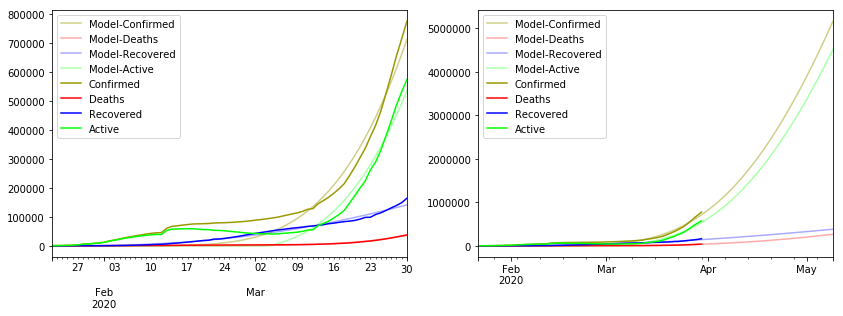

In [14]:
stats = []

df = full_table[['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('Date').sum()
print('World COVID-19 Prediction (With China Data)')
opt_display_model(df, stats)

* **Predict World (Without China Data) **

Because china ahead of the world, so maybe exclude china data sounds resonable, the tend looks more worse!

World COVID-19 Prediction(Without China Data)


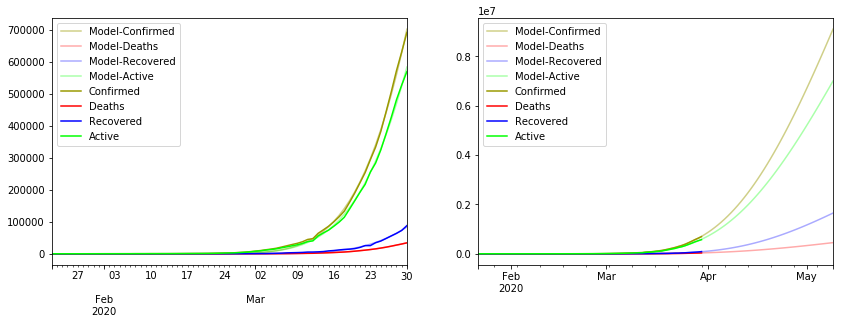

In [15]:
stats = []

df = full_table[full_table['Country/Region'] != 'China'][['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered', 'Active']].groupby('Date').sum()
print('World COVID-19 Prediction(Without China Data)')
opt_display_model(df, stats)

# Predict by Province

Hong Kong COVID-19 Prediction


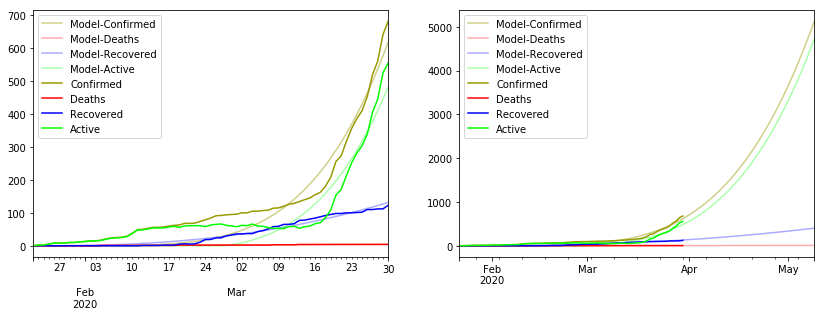

Shanghai COVID-19 Prediction


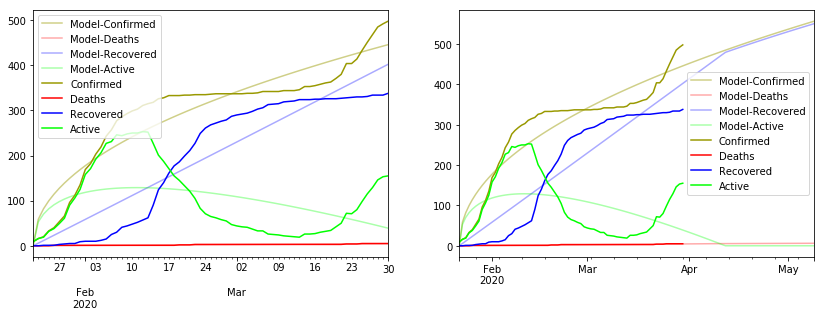

Anhui COVID-19 Prediction


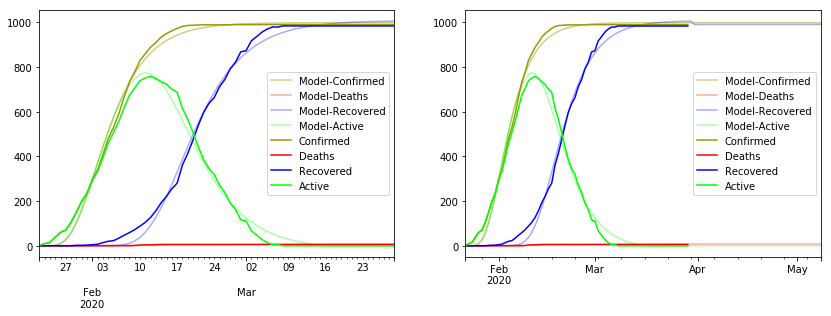

Hubei COVID-19 Prediction


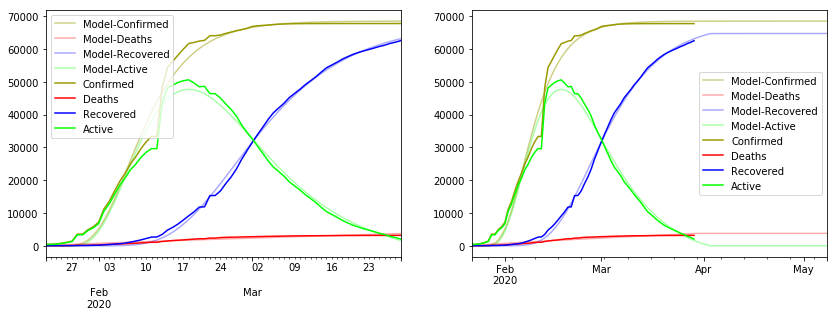

In [16]:
stats = []

# Province Specify
for Province in ['Hong Kong', 'Shanghai', 'Anhui', 'Hubei']:
    df = get_time_series_province(Province)
    print('{} COVID-19 Prediction'.format(Province))
    opt_display_model(df, stats)

# Predict by Specify Country

Singapore COVID-19 Prediction


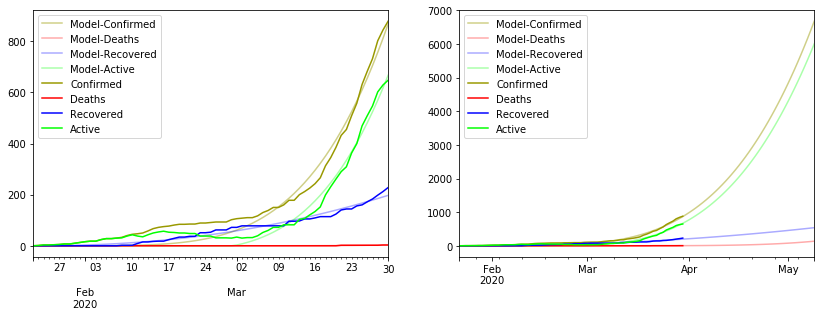

Russia COVID-19 Prediction


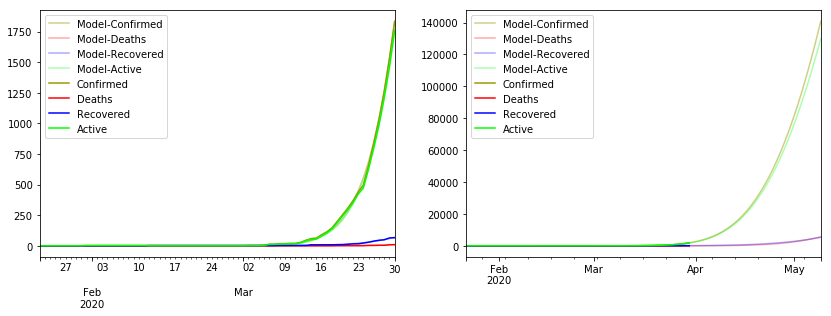

New Zealand COVID-19 Prediction


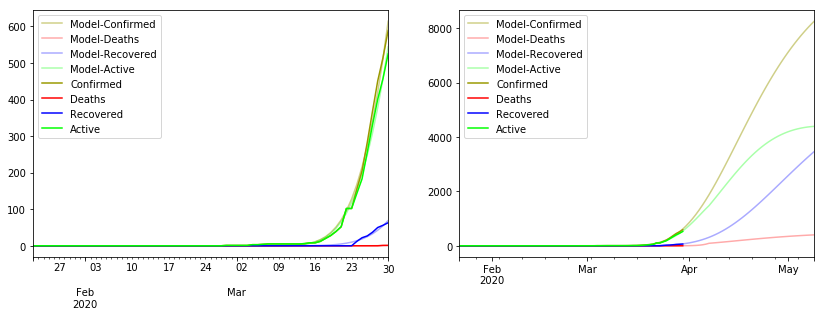

In [17]:
# Country Specify
stats = []
for country in ['Singapore', 'Russia', 'New Zealand']:
# for country in ['Sweden']:
    df = get_time_series(country)

    print('{} COVID-19 Prediction'.format(country))
    
    opt_display_model(df, stats)

# Predict all country greater than 1000

Australia COVID-19 Prediction


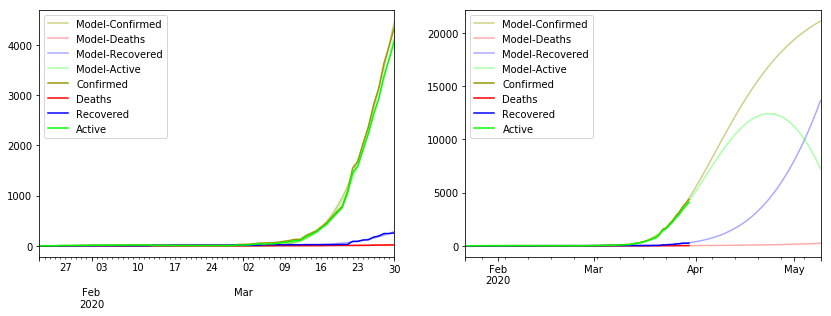

Austria COVID-19 Prediction


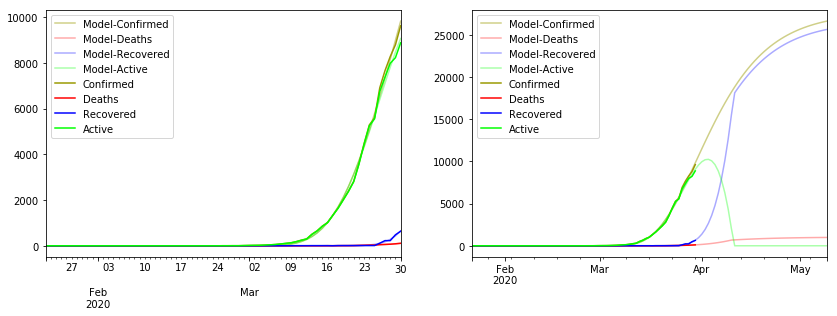

Belgium COVID-19 Prediction


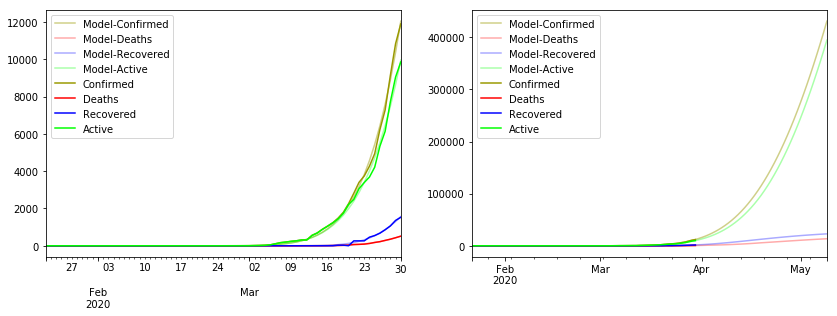

Brazil COVID-19 Prediction


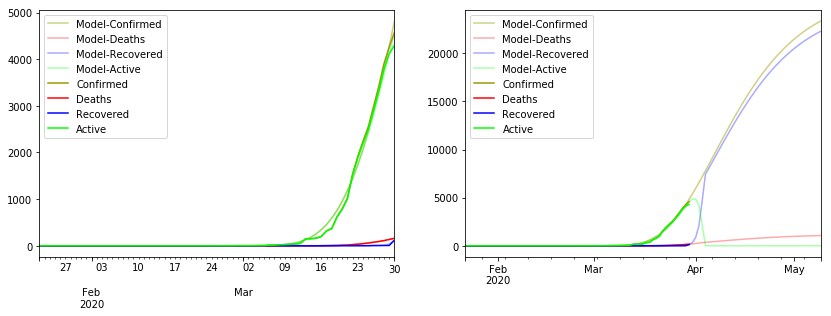

Chile COVID-19 Prediction


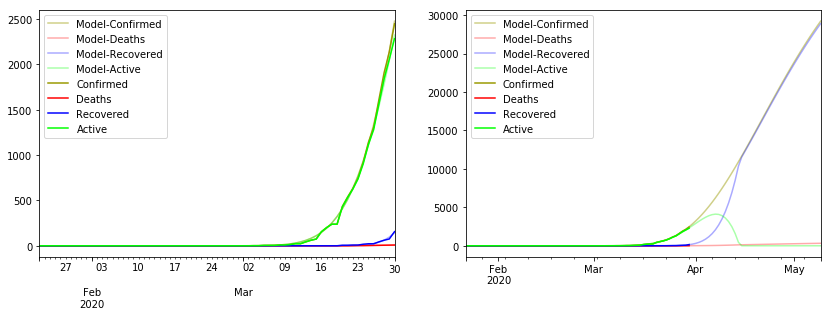

China COVID-19 Prediction


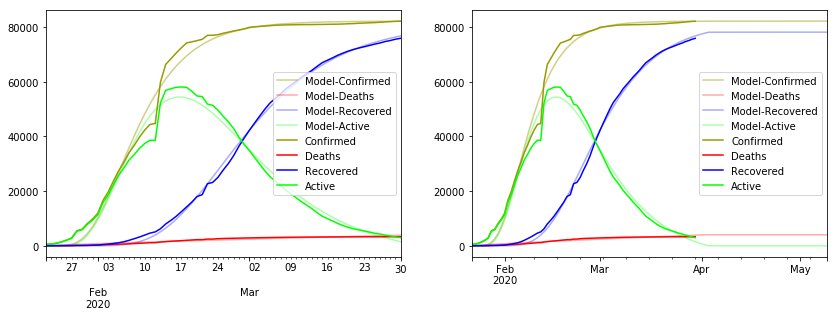

Czechia COVID-19 Prediction


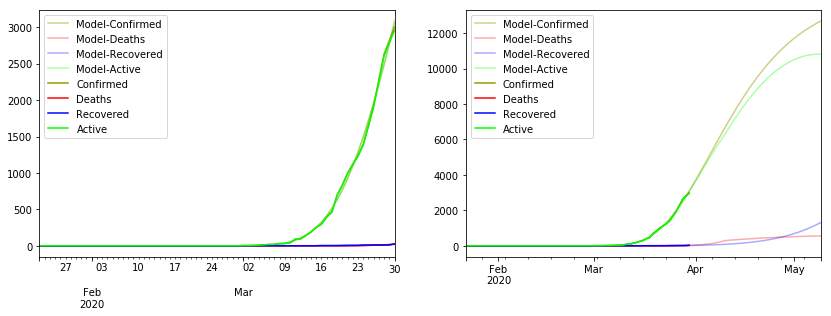

Denmark COVID-19 Prediction


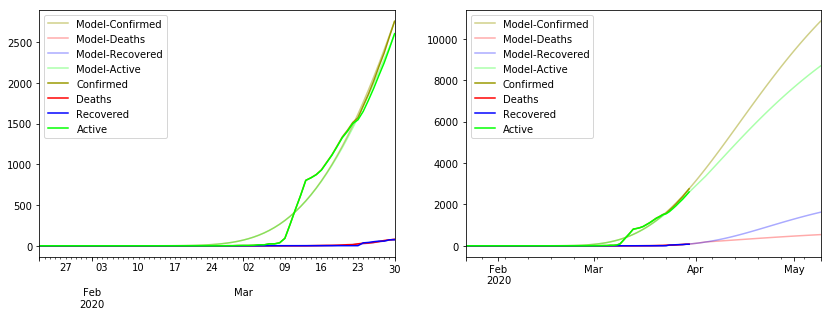

Ecuador COVID-19 Prediction


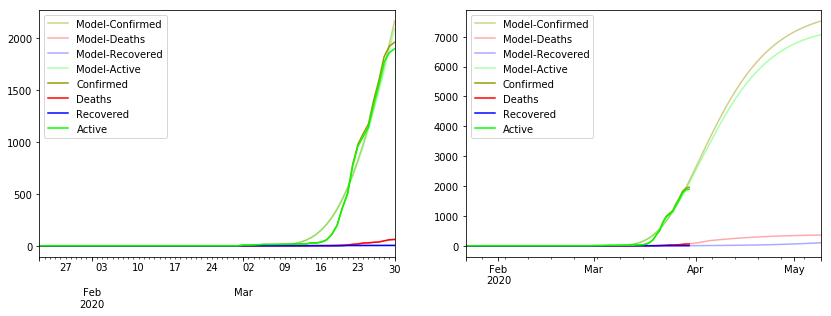

Finland COVID-19 Prediction


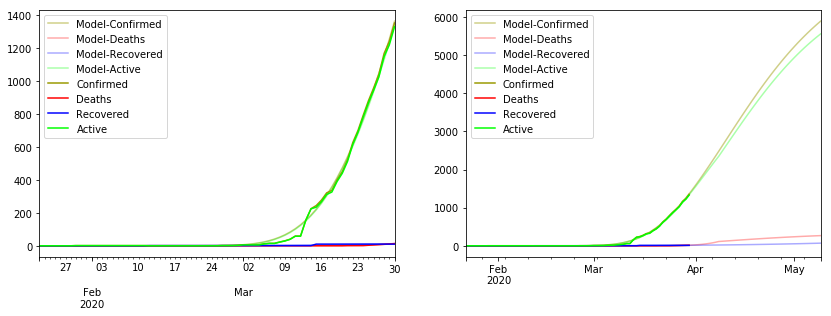

France COVID-19 Prediction


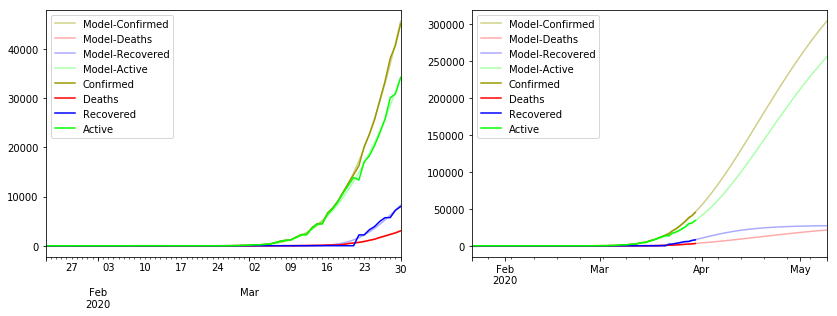

Germany COVID-19 Prediction


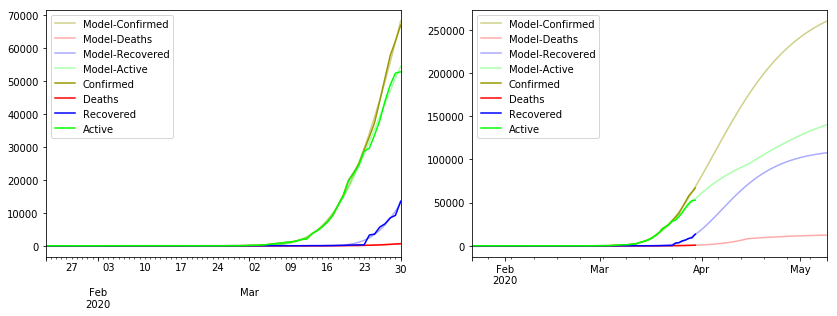

Greece COVID-19 Prediction


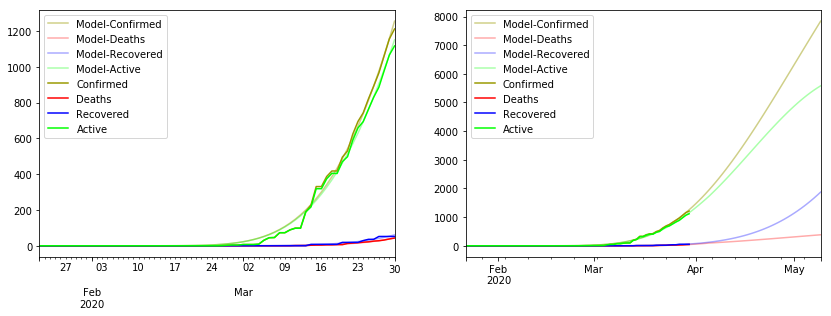

Iceland COVID-19 Prediction


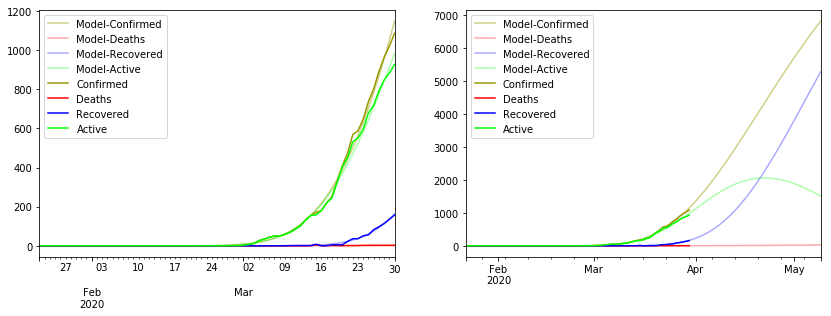

India COVID-19 Prediction


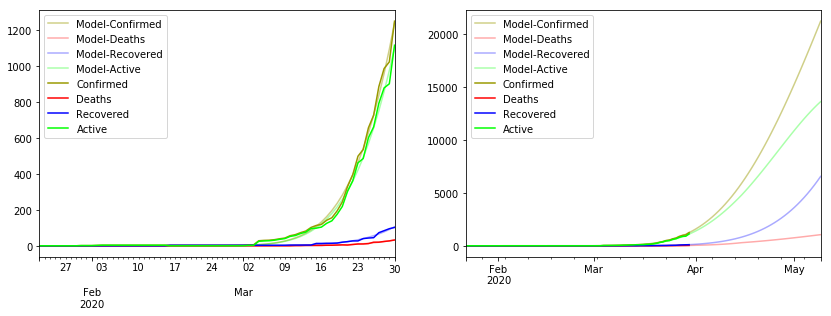

Indonesia COVID-19 Prediction


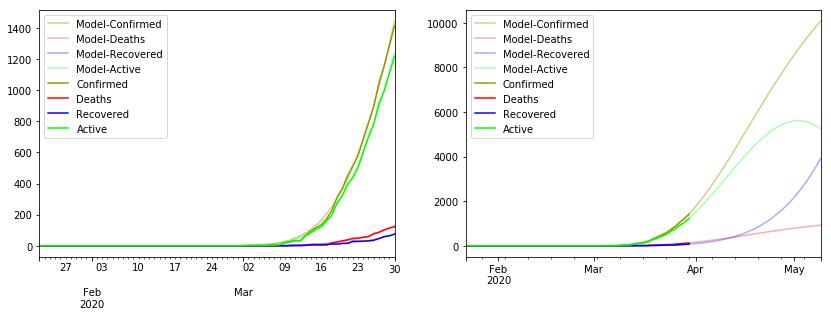

Iran COVID-19 Prediction


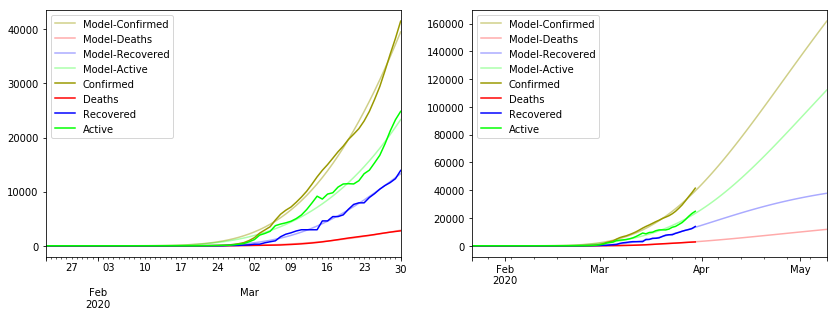

Ireland COVID-19 Prediction


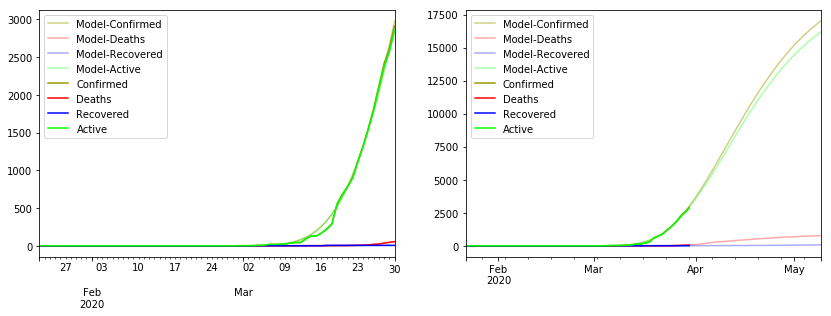

Israel COVID-19 Prediction


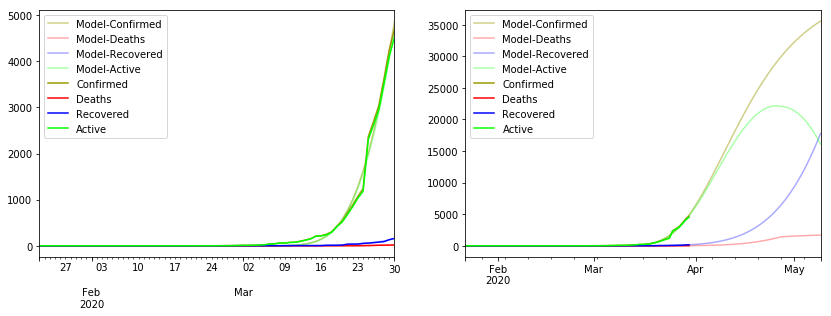

Italy COVID-19 Prediction


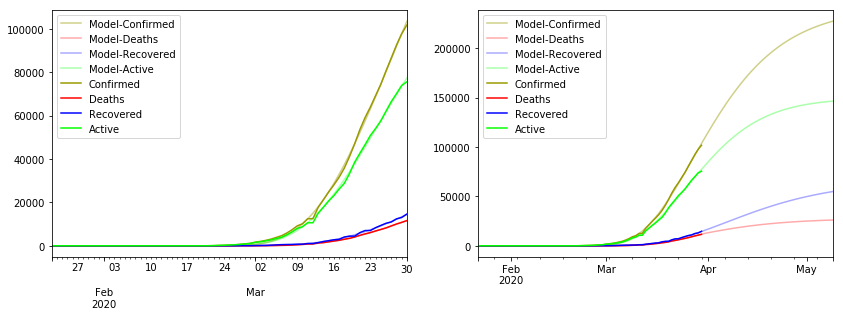

Japan COVID-19 Prediction


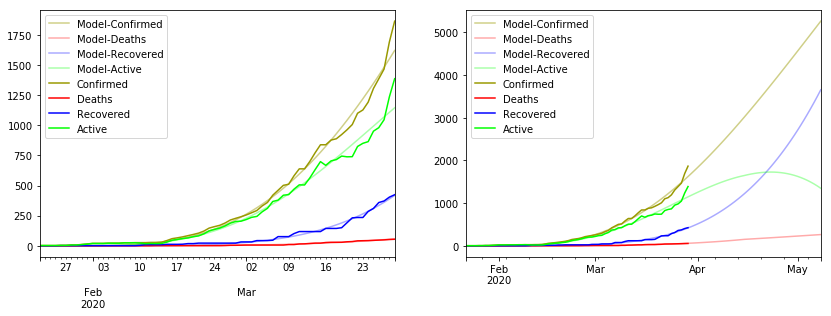

Korea, South COVID-19 Prediction


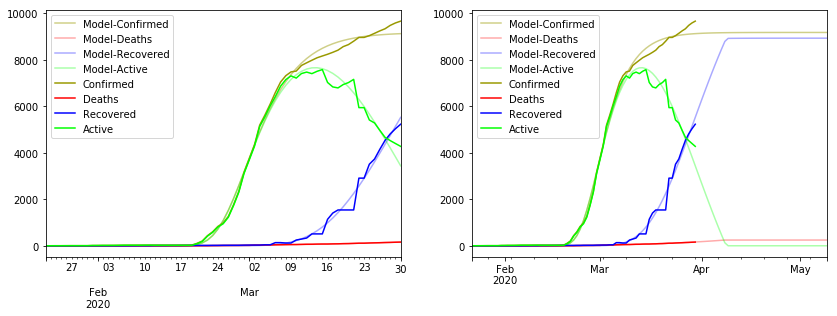

Luxembourg COVID-19 Prediction


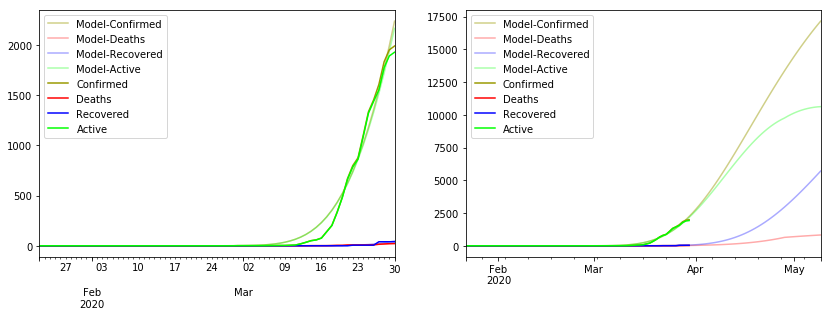

Malaysia COVID-19 Prediction


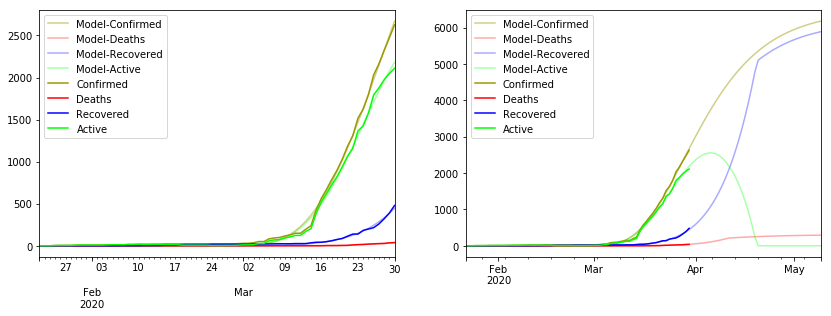

Netherlands COVID-19 Prediction


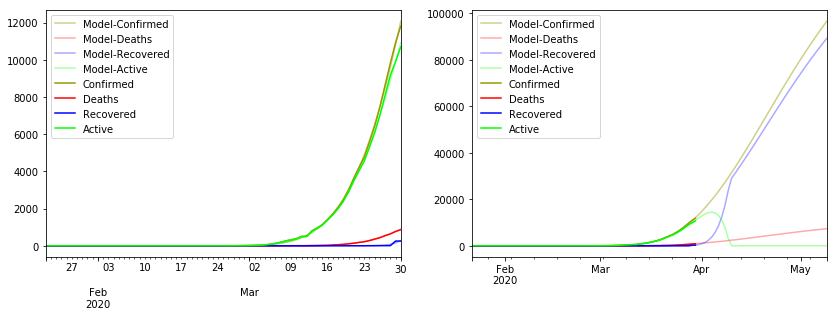

Norway COVID-19 Prediction


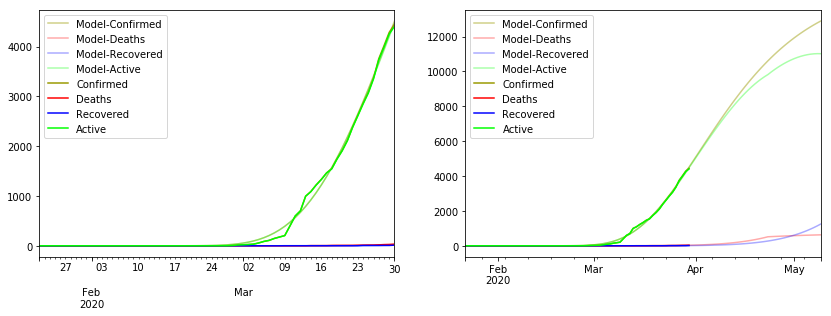

Pakistan COVID-19 Prediction


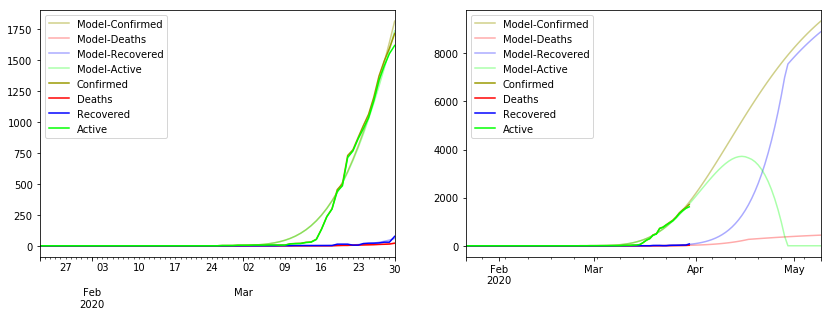

Philippines COVID-19 Prediction


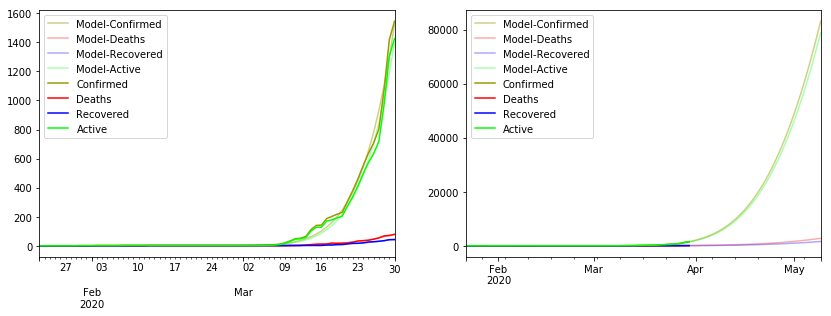

Poland COVID-19 Prediction


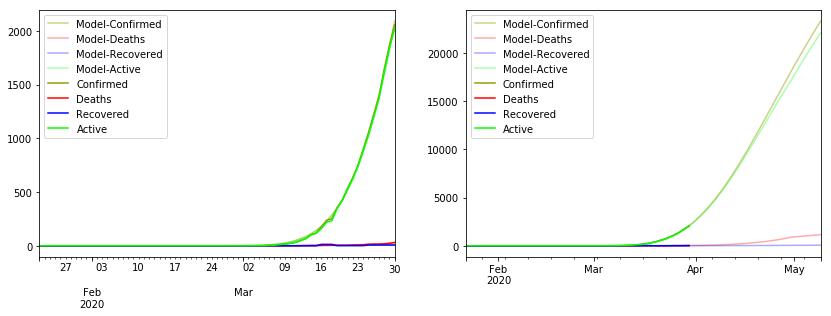

Portugal COVID-19 Prediction


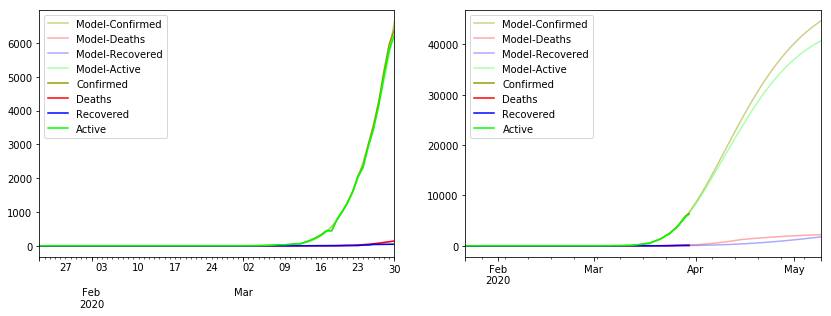

Romania COVID-19 Prediction


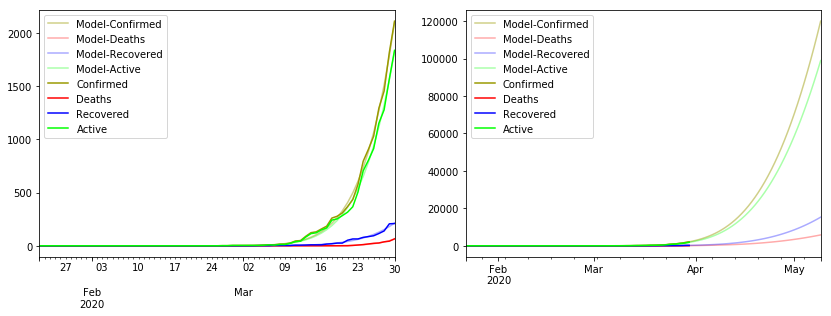

Russia COVID-19 Prediction


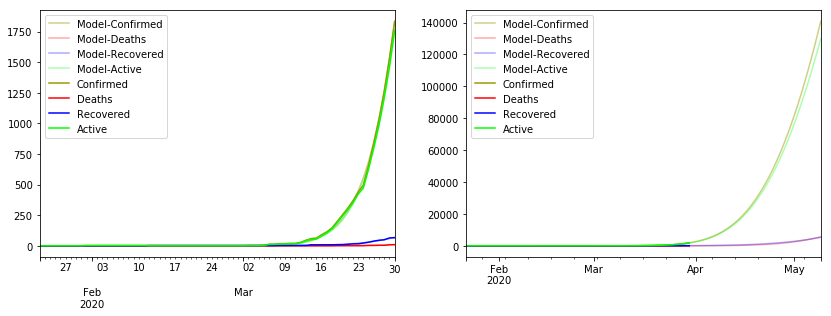

Saudi Arabia COVID-19 Prediction


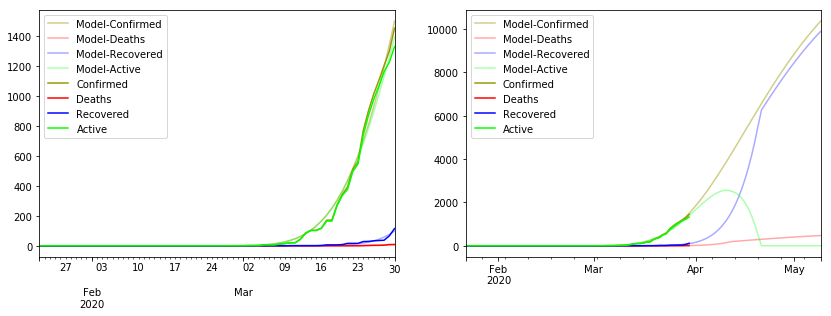

South Africa COVID-19 Prediction


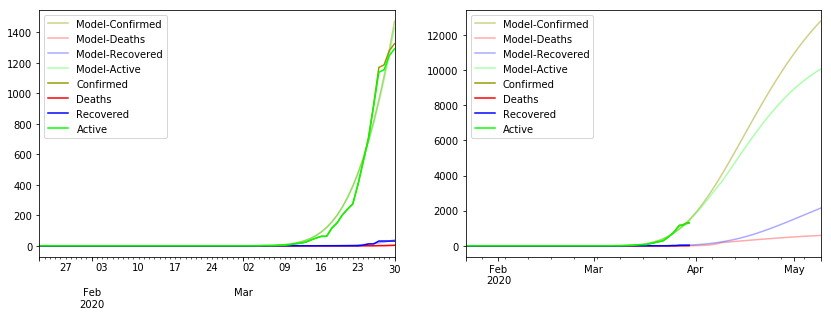

Spain COVID-19 Prediction


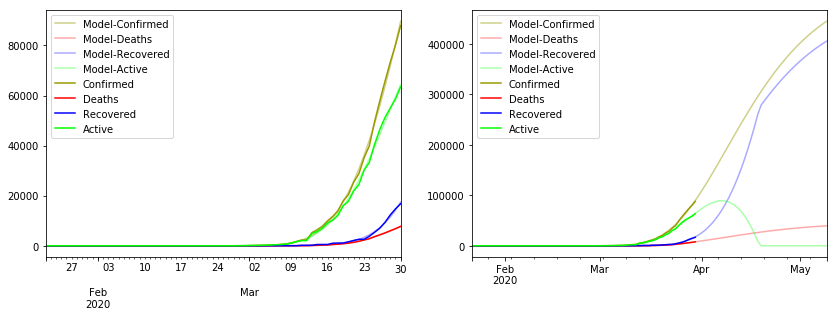

Sweden COVID-19 Prediction


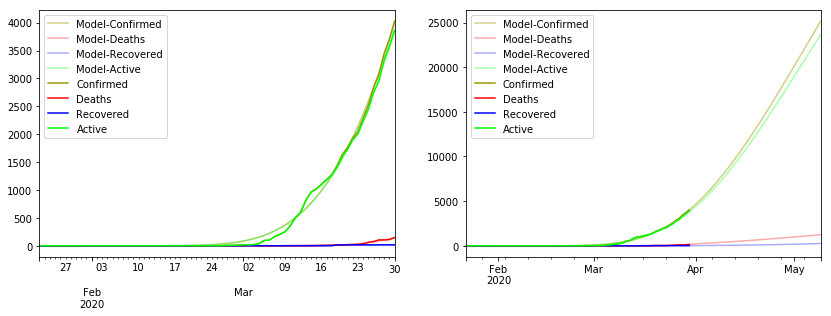

Switzerland COVID-19 Prediction


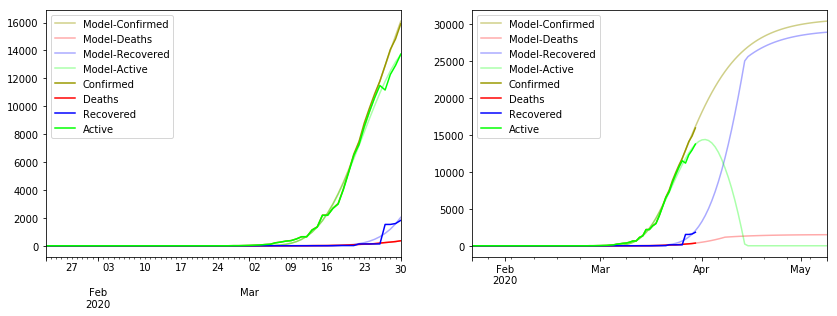

Thailand COVID-19 Prediction


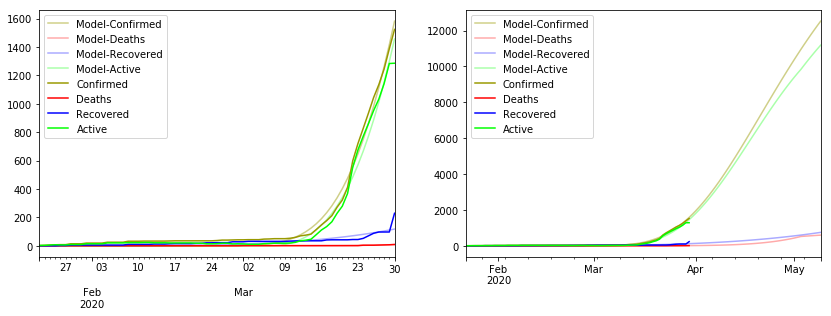

Turkey COVID-19 Prediction


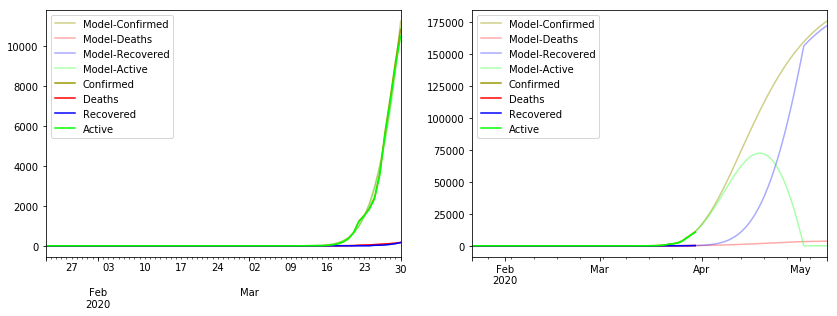

United Kingdom COVID-19 Prediction


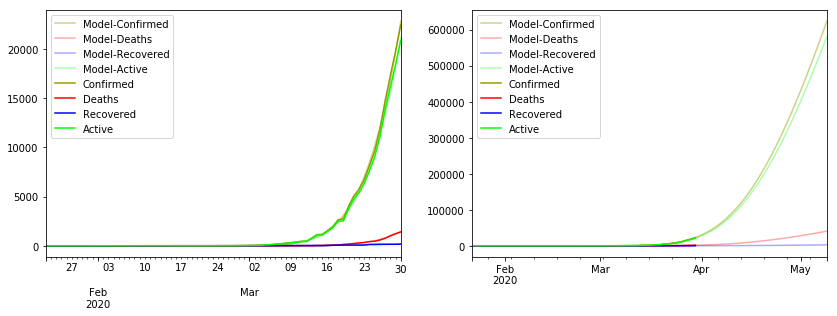

US COVID-19 Prediction


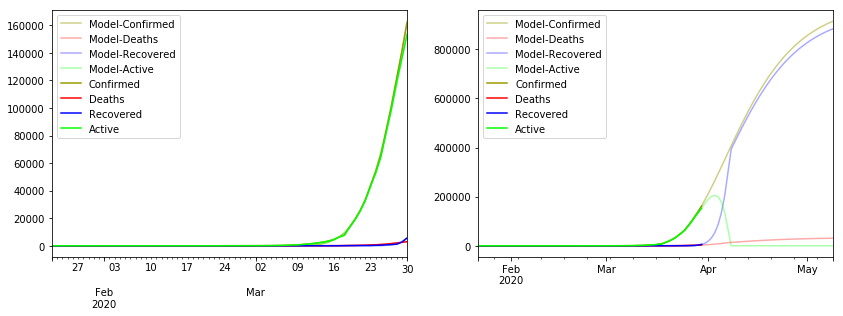

In [18]:
# All Country Confirmed Greater than 1000

stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 1000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 1000): 
        continue
    print('{} COVID-19 Prediction'.format(country))
    opt_display_model(df, stats)

let's see if we can make some sense from the parameters

In [19]:

stats_df = pd.DataFrame(stats)
# stats_df.columns = ['country', 'N', 'a', 'alpha', 'lag']
stats_df.columns = ['country', 'Confirmed-N', 'Confirmed-a', 'Confirmed-alpha', 'Deaths-N', 'Deaths-a', 'Deaths-alpha', 'Recorved-N', 'Recorved-a', 'Recorved-alpha']
stats_df

,country,Confirmed-N,Confirmed-a,Confirmed-alpha,Deaths-N,Deaths-a,Deaths-alpha,Recorved-N,Recorved-a,Recorved-alpha
0,Australia,"24,004",0,132,"1,295,518",0,6,"380,481",0,19
1,Austria,"27,665",0,282,"21,263",0,65,"407,372",0,413
2,Belgium,"3,477,636",0,24,"21,974",0,115,"29,331",0,189
3,Brazil,"26,293",0,153,"11,861",0,77,"65,918,606",0,"3,498"
4,Chile,"45,108",0,70,"27,729",0,37,"528,096",0,216
5,China,"82,216",0,7,"227,818",0,1,"81,811",0,15
6,Czechia,"14,268",0,118,"55,957",0,80,"828,472",0,14
7,Denmark,"16,575",0,19,"29,381",0,33,"2,559",0,101
8,Ecuador,"7,950",0,277,"34,132",0,31,"38,821",0,10
9,Finland,"7,696",0,39,"33,269",0,69,"262,075",0,4


In [20]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:20,.4f}'.format
stats_df.astype({'Confirmed-N': 'int'}).sort_values(by='Confirmed-N', ascending=False)

,country,Confirmed-N,Confirmed-a,Confirmed-alpha,Deaths-N,Deaths-a,Deaths-alpha,Recorved-N,Recorved-a,Recorved-alpha
2,Belgium,3477635,0.0232,24.4382,"21,973.9262",0.0506,114.9126,"29,331.0094",0.0614,188.6358
39,United Kingdom,2378299,0.0299,33.0658,"403,934.3995",0.0309,43.2790,"104,564.9049",0.0098,8.8078
30,Romania,1973545,0.0203,23.5979,"86,871.9465",0.0357,78.4487,"517,760.9296",0.0175,21.4575
31,Russia,1643757,0.0237,30.6389,"379,074.0323",0.0213,39.6734,"703,494.3182",0.0129,17.2257
27,Philippines,1431259,0.0198,22.7465,"185,026.2163",0.0122,13.5291,"51,811.5066",0.0148,15.4879
40,US,988012,0.0787,379.0299,"1,005,380.4418",0.0340,55.5617,"67,915,537.9211",0.0686,992.5395
34,Spain,526604,0.0586,94.1246,"40,735.3506",0.0774,317.6944,"3,155,190.5641",0.0375,63.8226
10,France,459525,0.0425,40.4918,"50,736.2256",0.0507,86.5108,"27,661.6525",0.1062,"1,651.3433"
16,Iran,341189,0.0249,10.6127,"12,907.6023",0.0400,21.9658,"47,770.2032",0.0419,21.3575
11,Germany,289763,0.0646,116.7445,"400,654.1217",0.0297,45.2508,"112,718.0592",0.0962,"1,497.3201"


N is the potential spread in the country if the dynamics since the beginning of the epidemy persist. One problem is that sometimes we're measuring the spread of testing rather than of the epidemy. For instance New York allegedly started tesing a lot of people, which might explain the current explosive dynamic in the US numbers.

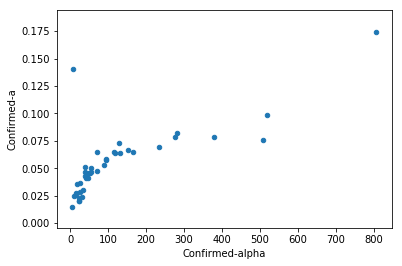

In [21]:
ax = stats_df.plot.scatter(x='Confirmed-alpha', y='Confirmed-a')
# ax.set_xlim([0, 100])
plt.show()